# Homework 5 - COMP 135 - Intro to Machine Learning
Francis Straceski 
ID: 1220064
Last Updated: 11/16/2019

## Download cifar10 Dataset, Plot 9 of the images

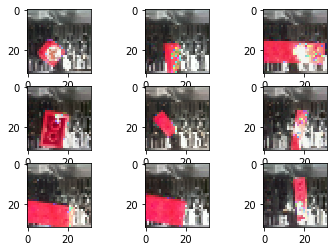

In [248]:
# Plot ad hoc CIFAR10 instances
#from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
#import cv2

red_train_size = 100
other_train_size = 150
red_test_size = 50
other_test_size = 50

# load data
X_train = np.zeros((red_train_size + other_train_size,32,32,3,))
y_train = np.zeros((red_train_size + other_train_size,1))
X_test = np.zeros((red_test_size + other_test_size,32,32,3,))
y_test = np.zeros((red_test_size + other_test_size,1))

for i in range(red_train_size):
    #x1 = np.load('red/red' + str(i + 1) + '.npy')
    x1 = np.load('red_rgb/red' + str(i + 1) + '.npy')
    X_train[i,:,:,:] = x1
    y_train[i] = 0 
    
for i in range(other_train_size+1):
    #x1 = np.load('other/other' + str(i + 1) + '.npy')
    x1 = np.load('other_rgb/other' + str(i + 1) + '.npy')
    X_train[i+red_train_size-1,:,:,:] = x1
    y_train[i+red_train_size-1] = 1
    
for i in range(red_test_size):
    #x1 = np.load('red/red' + str(i + red_train_size) + '.npy')
    x1 = np.load('red_rgb/red' + str(i + red_train_size) + '.npy')
    X_test[i,:,:,:] = x1
    y_test[i] = 0 
    
for i in range(other_test_size+1):
    #x1 = np.load('other/other' + str(i + other_train_size) + '.npy')
    x1 = np.load('other_rgb/other' + str(i + other_train_size) + '.npy')
    X_test[i+red_test_size-1,:,:,:] = x1
    y_test[i+red_test_size-1] = 1

# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    hsv = X_train[i]
    #rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    normal = Normalize(vmin=0.0, vmax=1.0, clip=False)
    plt.imshow(hsv/255, norm=normal) # normalizing not working for some reason, use hsv/255
# show the plot
plt.show()

## Import functions needed to make a CNN

In [249]:
# Simple CNN model for CIFAR-10
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

Load data, Normalize data to 0.0-1.0 the data by casting to floating point and dividing by 255.

In [250]:
# normalize inputs from 0-255 to 0.0-1.0  
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [251]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(250, 32, 32, 3)
(250, 1)
(100, 32, 32, 3)
(100, 1)


One hot encode outputs, converts each output class (0-9) to a 1x10 binary matrix with the corresponding class identified.
E.g. class 4 becomes [0 0 0 0 1 0 0 0 0 0].

In [252]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# Designing a simple Neural Network
Now we will design a simple neural network based off the tutorial's recomendation.
This network will have 8 components:

1. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
    - We will make 32 feature maps using convolution. Each will be size 32x32, the same as the original 32x32 images.
      An area of size 3x3 will be used to traverse each image. Afterwards we use a ReLU activation function on each
      convolutional map. We also will limit our weights such that the two-norm of the weight matrix is capped at 3. 
      ||A||_2 <= 3.
      
2. Dropout set to 20%.
    - Drop 20% of input units to next layer while training. This is a simple method to prevent overfitting on the data.
    
3. Convolutional layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
    - Add a second convolutional layer after dropout. Generate from 80% of the previous convolutional layer.
      Once again this will produce a 32x32x32 output, and be generated with a 3x3 feature area.
    
4. Max Pool layer with size 2×2.
    - Downsample each 32x32 layer with a 2x2 area. Take the max value of each 2x2 area and create a 16x16 layer.
    
5. Flatten layer.
    - Flattens the 16x16x32 layer into a single dimension (size 8192).
    
6. Fully connected layer with 512 units and a rectifier activation function.
    - Fully connects flattened layer to 512 neurons using ReLU actiavtion.

7. Dropout set to 50%.
    - Drop 50% of inputs to the final output layer. Once again to prevent overfitting of data. We want the inputs
      to the output layer to be as general as possible for each class.

8. Fully connected output layer with 10 units and a softmax activation function.
    - Takes 50% of inputs from the fully connected layer and passes them to the output layer. Each unit predicts the 
      probability of a picture belong to one of the 10 classes, calculated using the softmax (sigmoid) function.
      
Even though this network is relatively sparse, it should be able to show how by using methods such as convolution and dropout, we can obtain relatively accurate results on the data set.

In [253]:
# Model Code taken directly from:
# https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.1))
#model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_95 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_96 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 2)               

# Simple Neural Network Evaluation

As we can see, even a simple neural network was able to acheive 70% Accuracy on the validation data. The loss on the training data continuously decreased over each epoch, while the validation loss steadily decreased for about 5 epochs before fluctuating from 0.94 to 1.01. Overall our model is relatively simplistic and was already achieving over 69% accuracy after 15 epochs.

By designing a more complex neural network, we can imporve accuracy by identifying even more non-linearities in the data set. This will help our classifier identify more unique features of images that can help identify them. Additionally, we must be wary of overfitting. To do this we will keep using dropout to maintain a level of generality between layers. 

In [254]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 250 samples, validate on 100 samples
Epoch 1/50
250/250 [==============================] - 1s 3ms/step - loss: 0.4848 - accuracy: 0.7960 - val_loss: 0.1940 - val_accuracy: 0.9800
Epoch 2/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0925 - accuracy: 0.9840 - val_loss: 0.0835 - val_accuracy: 0.9700
Epoch 3/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0396 - accuracy: 0.9880 - val_loss: 0.0984 - val_accuracy: 0.9700
Epoch 4/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0474 - accuracy: 0.9920 - val_loss: 0.1144 - val_accuracy: 0.9700
Epoch 5/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0194 - accuracy: 0.9960 - val_loss: 0.0524 - val_accuracy: 0.9700
Epoch 6/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0295 - accuracy: 0.9920 - val_loss: 0.0933 - val_accuracy: 0.9700
Epoch 7/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0164 - accuracy: 0.9960 - 

Failed, Should be Color #0


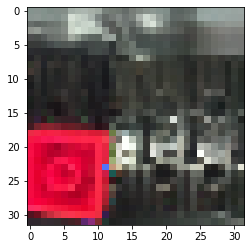

Failed, Should be Color #0


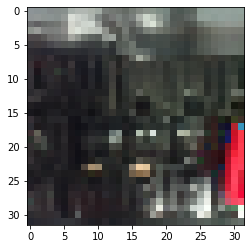

Failed, Should be Color #0


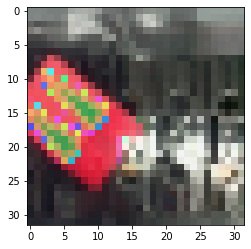

In [255]:
prob = model.predict(X_test)
failed_idx = []
for i in range(len(prob)):
    if prob[i][0] > prob[i][1]:
        prediction = 0
    else:
        prediction= 1
    
    if y_test[i][prediction] != 1:
        failed_idx.append(i)

for i in failed_idx:
    color = 0
    for j in y_test[i]:
        if j == 1:
            break
        else:
            color += 1 
    
    print("Failed, Should be Color #" + str(color))

    plt.imshow(X_test[i], norm=normal)
    plt.show()

In [256]:
model.save('100r150.h5')

# Designing a more complicated neural network

Our more complex neural network will still follow the same general idea as before: Input into a convolutional layer, dropout convolution, pool, flatten, fully-connected, dropout, output.

This time, we will use a 6 convolutional layres and 3 dropout layers. We will again be repeating the patern of convolution - 20% dropout, convolution, max pool. The reason we do this, is to generate a larger amount of feature maps. By Pooling inbetween the 32 and 64 feature-map convolution layers, we generate more feature maps but with a smaller size, due to the pooling. This means after the last pooling (after the 6th convo layer) we have an output of size 4x4x128.

Additionally, after we flatten the 4x4x128 output, we will use two fully-connected neural networks instead of one. This will help produce catch more non-linear separations between the classes before reaching the output layer.

In [247]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 100
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_89 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_90 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 16, 16, 64)      

# Complex Neural Network Evaluation

As we can see, by making a more complex neural network, we were able to achieve far better accuracy and loss on the validation set than before. Additionally, as the epochs increase we see an increase in accuracy and a decrease in loss among both data sets, meaning that this network is not overfitted AND could likely reach better results with more iterations.

By increasing the convolution feature maps and adding another fully connected layer, more non-linearities in the dataset were able to be discovered by the network. 

In [238]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 350 samples, validate on 100 samples
Epoch 1/50
350/350 [==============================] - 0s 1ms/step - loss: 3.9611e-04 - accuracy: 1.0000 - val_loss: 0.4145 - val_accuracy: 0.8100
Epoch 2/50
350/350 [==============================] - 0s 1ms/step - loss: 4.3963e-04 - accuracy: 1.0000 - val_loss: 0.4202 - val_accuracy: 0.8100
Epoch 3/50
350/350 [==============================] - 0s 1ms/step - loss: 3.3562e-04 - accuracy: 1.0000 - val_loss: 0.4281 - val_accuracy: 0.8100
Epoch 4/50
350/350 [==============================] - 0s 1ms/step - loss: 2.3594e-04 - accuracy: 1.0000 - val_loss: 0.4360 - val_accuracy: 0.7900
Epoch 5/50
350/350 [==============================] - 0s 1ms/step - loss: 2.5474e-04 - accuracy: 1.0000 - val_loss: 0.4353 - val_accuracy: 0.7900
Epoch 6/50
350/350 [==============================] - 0s 1ms/step - loss: 3.2877e-04 - accuracy: 1.0000 - val_loss: 0.4321 - val_accuracy: 0.8100
Epoch 7/50
350/350 [==============================] - 0s 1ms/step - loss: 2.52

# END OF TUTORIAL

# Training with more epochs

As suggested in the tutorial, it is common to train neural networks on hundreds or even thousands of epochs. By increasing the epochs, this should give more opportunity for the network to adjust its weights and produce more accurate results.

We will test the complex neural network using 75 epochs to see if this gives a substantial increase in accuracy. From the 25 epoch test, we see that the accuracy doesn't fluctuate or plateau like with the simple network. If the data continues to follow this trend, we should expect to see a non-trivial increase in accuracy by doubling the epoch size.

In [21]:
# Run complex model with 50 MORE Epochs

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 168s 3ms/step - loss: 0.4040 - accuracy: 0.8567 - val_loss: 0.6258 - val_accuracy: 0.7917
Epoch 2/50
50000/50000 [==============================] - 167s 3ms/step - loss: 0.3886 - accuracy: 0.8606 - val_loss: 0.6328 - val_accuracy: 0.7894
Epoch 3/50
50000/50000 [==============================] - 171s 3ms/step - loss: 0.3816 - accuracy: 0.8632 - val_loss: 0.6219 - val_accuracy: 0.7929
Epoch 4/50
50000/50000 [==============================] - 169s 3ms/step - loss: 0.3693 - accuracy: 0.8683 - val_loss: 0.6216 - val_accuracy: 0.7921
Epoch 5/50
50000/50000 [==============================] - 168s 3ms/step - loss: 0.3612 - accuracy: 0.8721 - val_loss: 0.6192 - val_accuracy: 0.7980
Epoch 6/50
50000/50000 [==============================] - 167s 3ms/step - loss: 0.3517 - accuracy: 0.8755 - val_loss: 0.6288 - val_accuracy: 0.7945
Epoch 7/50
50000/50000 [==============================] - 166s

# Adding More Fully-Connected Layers in between Convolution Layers

We know that using fully-connected layers are vital to detecting non-linearities and correlations in the data set. By adding more Fully-Connected layers, we might be able to detect more non-linear behavior to help our classifier. We will include a 20% Dropout to ensure that we are not overfitting our data, which is more likely to occur when adding another fully-connected layer.

In [46]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2048, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_34 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)       

In [47]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 205s 4ms/step - loss: 1.9885 - accuracy: 0.2602 - val_loss: 1.6736 - val_accuracy: 0.3775
Epoch 2/25
50000/50000 [==============================] - 204s 4ms/step - loss: 1.5852 - accuracy: 0.4194 - val_loss: 1.4171 - val_accuracy: 0.4801
Epoch 3/25
50000/50000 [==============================] - 201s 4ms/step - loss: 1.3822 - accuracy: 0.4941 - val_loss: 1.2766 - val_accuracy: 0.5385
Epoch 4/25
50000/50000 [==============================] - 204s 4ms/step - loss: 1.2420 - accuracy: 0.5483 - val_loss: 1.2407 - val_accuracy: 0.5461
Epoch 5/25
50000/50000 [==============================] - 203s 4ms/step - loss: 1.1315 - accuracy: 0.5942 - val_loss: 1.0926 - val_accuracy: 0.6052
Epoch 6/25
50000/50000 [==============================] - 203s 4ms/step - loss: 1.0388 - accuracy: 0.6274 - val_loss: 0.9983 - val_accuracy: 0.6406
Epoch 7/25
50000/50000 [==============================] - 207s

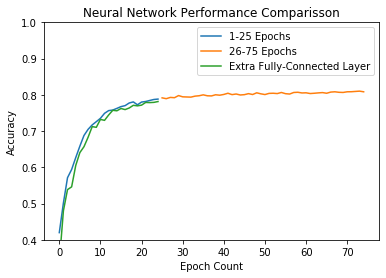

In [57]:
import numpy as np
from matplotlib import pyplot as plt

Epoch_num = [i for i in range(75)]
complex_25_acc = [0.4198, 0.5016, 0.5714, 0.5940, 0.6269, 0.6584, 0.6878, 0.7048, 0.7170, 0.7260, 0.7352, 0.7490, 0.7565, 0.7580, 0.7626, 0.7675, 0.7702, 0.7775, 0.7805, 0.7725, 0.7801, 0.7816, 0.7845, 0.7872, 0.7883]
complex_75_acc = [0.7917, 0.7894, 0.7929, 0.7921, 0.7980, 0.7945, 0.7941, 0.7937, 0.7964, 0.7975, 0.8000, 0.7974, 0.7970, 0.8002, 0.7990, 0.8011, 0.8044, 0.8006, 0.8023, 0.7996, 0.8005, 0.8033, 0.8009, 0.8056, 0.8028, 0.8008, 0.8040, 0.8044, 0.8035, 0.8065, 0.8032, 0.8022, 0.8065, 0.8071, 0.8052, 0.8056, 0.8036, 0.8044, 0.8054, 0.8062, 0.8044, 0.8076, 0.8084, 0.8070, 0.8066, 0.8084, 0.8086, 0.8094, 0.8102, 0.8084]
extra_full_acc = [0.3375, 0.4801, 0.5385, 0.5461, 0.6052, 0.6406, 0.6569, 0.6829, 0.7123, 0.7104, 0.7322, 0.7296, 0.7444, 0.7573, 0.7560, 0.7623, 0.7593, 0.7637, 0.7711, 0.7696, 0.7716, 0.7790, 0.7786, 0.7792, 0.7815]

plt.plot(Epoch_num[0:25], complex_25_acc, Epoch_num[25:], complex_75_acc, Epoch_num[0:25], extra_full_acc)
plt.title("Neural Network Performance Comparisson")
labels = ["1-25 Epochs", "26-75 Epochs", "Extra Fully-Connected Layer"]
plt.legend(labels)
plt.ylim([0.4, 1]);
plt.xlabel("Epoch Count");
plt.ylabel("Accuracy");

# Neural Network Comparison

As expected, we saw a noticable increase of accuracy by training the complex neural network for 50 more epochs. We were able to increase the accuracy from 78.83% to 80.84%. The accuracy seems to be slightly plateued, but better accuracy may be achieveable with hundreds or thousands of epochs, as mentioned in the tutorial. This highlights how Neural Networks have the ability to optimize overtime, but at a heavy computational cost.

Adding an additional fully-connected layer to the complex neural network seemed to slightly decrease accuracy over the first 25 epochs. Before, when we converted from the simple to complex network, we assumed that adding another fully connected layer would help the classification process. It appears that the slight decrease in accuracy might be a result of overfitting, as the loss on the training data is consistantly slightly lower for the network with 3 fully-connected layers.

This observation leads me to believe that there may be some overfitting in the original model produced by the tutorial.
To solve this issue, perhaps we should increase the dropout percentage for the fully-connected layers, or use a bigger area when performing convolution. 

In [1]:
x_train

NameError: name 'x_train' is not defined

In [4]:
X_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        